# FQI on the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import os
import json

parameters = json.load(open("parameters.json"))
n_states = parameters["n_states"]
n_actions = parameters["n_actions"]
sucess_probability = parameters["sucess_probability"]
gamma = parameters["gamma"]
env_seed = parameters["env_seed"]

# Sample collection
n_repetitions = parameters["n_repetitions"]
n_samples = n_states * n_actions * n_repetitions

# Trainings
max_bellman_iterations = parameters["max_bellman_iterations"]
fitting_steps = 50 * 4
batch_size_samples = n_states
learning_rate = {"first": 0.01, "last": 0.00001, "duration": fitting_steps * n_samples // batch_size_samples}

# Search for an unused seed
max_used_seed = 0
for file in os.listdir("figures/data/FQI/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
env_key = jax.random.PRNGKey(env_seed)
seed = max_used_seed + 1
key = jax.random.PRNGKey(seed)
shuffle_key, dummy_q_network_key, _, _ = jax.random.split(key, 4) # 4 keys are generated to be coherent with the other trainings

## Define environment

In [2]:
import numpy as np
from pbo.environment.chain_walk import ChainWalkEnv


states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = np.arange(n_states + 1) - 0.5
actions_boxes = np.arange(n_actions + 1) - 0.5

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for _ in range(n_repetitions):
            env.reset(jnp.array([state]))
            next_state, reward, absorbing, _ = env.step(jnp.array([action]))

            replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

replay_buffer.cast_to_jax_array()

### Visualize samples

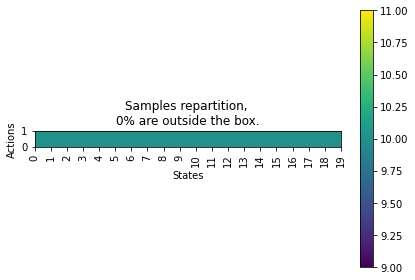

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, _ = count_samples(replay_buffer.states, replay_buffer.actions, states_boxes, actions_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Train FQI

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  0%|          | 0/5 [00:00<?, ?it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]


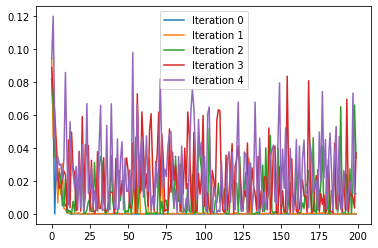

In [5]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import TableQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = TableQ(1, n_states, 1, n_actions, gamma, dummy_q_network_key, None, None, learning_rate, zero_initializer=True)
validation_initial_weight = q.to_weights(q.params)

q_functions = np.zeros((max_bellman_iterations + 1, n_states, n_actions))
bellman_iteration_functions = np.zeros((max_bellman_iterations + 1, n_states, n_actions))
v_functions = np.zeros((max_bellman_iterations + 1, n_states))

params_target = q.params
q_i = q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions)[0]
policy_q = q_i.argmax(axis=1)

q_functions[0] = q_i
v_functions[0] = env.value_function(policy_q)
print(policy_q)
cumulative_l2_loss = np.zeros((max_bellman_iterations, fitting_steps)) * np.nan

for bellman_iteration in tqdm(range(1, max_bellman_iterations + 1)):
    q.reset_optimizer()
    
    for step in range(fitting_steps):
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
        cumulative_l2_loss[bellman_iteration - 1, step] = l2_loss
    q_i = q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions)[0]
    policy_q = q_i.argmax(axis=1)

    q_functions[bellman_iteration] = q_i
    bellman_iteration_functions[bellman_iteration] = env.apply_bellman_operator(q_i)
    v_functions[bellman_iteration] = env.value_function(policy_q)
    print(policy_q)

    params_target = q.params

for bellman_iteration in range(max_bellman_iterations):
    plt.plot(cumulative_l2_loss[bellman_iteration], label=f"Iteration {bellman_iteration}")
plt.legend()
plt.show()

## Save data

In [6]:
np.save(f"figures/data/FQI/{max_bellman_iterations}_Q_{seed}.npy", q_functions)
np.save(f"figures/data/FQI/{max_bellman_iterations}_BI_{seed}.npy", bellman_iteration_functions)
np.save(f"figures/data/FQI/{max_bellman_iterations}_V_{seed}.npy", v_functions)